## Исследование надежности заемщиков.


Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок.

Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Обзор данных

In [1]:
# импорт библиотеки pandas
# чтение файла с данными и сохранение в data
# получение первых 10 строк таблицы data
import pandas as pd

data = pd.read_csv('/datasets/data.csv')
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [2]:
# получение общей информации о данных в таблице data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В таблице 12 столбцов.

Описание данных
* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита
    
В данных есть некоторые нарушения:
1. Общий трудовой стаж в днях указан с отрицательным значением.
2. Трудовой стаж в днях, поэтому тип данных должен быть int, а не float.
3. В столбце уровень образования клиента указаны значения с разными регистрами.
    
Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

Предварительно можно утверждать, что, данных достаточно для проверки гипотез. Но встречаются пропуски в данных, неявные дубликаты и анамальные значения.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

### Шаг 2.1 Заполнение пропусков

In [3]:
# количество пропусков
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [4]:
# доля пропусков
d = data['days_employed'].isna().sum() / len(data['income_type'])
print(f'Пропущено {d:.0%} от всех данных')

Пропущено 10% от всех данных


В столбцах `days_employed` и `total_income` одинаковое количество пропущенных значений, возможно они безработные, студенты или пенсионеры. Значения стажа и доходов пропущено 2174 раза, это 10% от всех значений датафрейма в котором 21525 строк. Это довольно большая часть данных и их удаление может повлиять на результат. Поэтому лучше заменить их на средние или медианное значение. В столбце со стажем присутствуют как слишком большие значения, так и слишком маленькие, поэтому предпочтительней заменить пропуски медианной.

In [5]:
# присвоение пропускам значение медианны и проверка результата
data.loc[data['days_employed'].isna(), 'days_employed'] = data.groupby('dob_years')['days_employed'].transform('median')
data.loc[data['total_income'].isna(), 'total_income'] = data.groupby('income_type')['total_income'].transform('median')
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Пропусков в данных больше нет.

<a id='2.2'></a>
### Шаг 2.2 Проверка данных на аномалии и исправления.

Мы уже заметили, что в данных есть аномалии.

* В `days_employed` отрицательные значения.
* В столбце `education` указаны значения с разными регистрами.
* Общий трудовой стаж в днях `days_employed` и `total_income` указан в **float**, а не в **int**.

Нужно проверить другие значения столбцов.

In [38]:
# вывод уникальных значений каждого столбца
data_columns = ['children', 'days_employed', 'dob_years', 'education', 'education_id', 'family_status', 
                'family_status_id', 'gender', 'income_type', 'debt', 'total_income', 'purpose']

for i in data_columns:
    print( i, data[i].unique())

children [ 1  0  3  2 -1  4 20  5]
days_employed [-8437.67302776 -4024.80375385 -5623.42261023 ... -2113.3468877
 -3112.4817052  -1984.50758853]
dob_years [42 36 33 32 53 27 43 50 35 41 40 65 54 56 26 48 24 21 57 67 28 63 62 47
 34 68 25 31 30 20 49 37 45 61 64 44 52 46 23 38 39 51  0 59 29 60 55 58
 71 22 73 66 69 19 72 70 74 75]
education ['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']
education_id [0 1 2 3 4]
family_status ['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']
family_status_id [0 1 2 3 4]
gender ['F' 'M' 'XNA']
income_type ['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']
debt [0 1]
total_income [253875.6394526  112080.01410244 145885.95229686 ...  89672.56115303
 244093.05050043  82047.41889948]
purpose ['по

Уникальных значений в столбцах `days_employed` и `total_income` слишком много, посмотрим их описательную статистику.

count     21525.000000
mean      63148.314919
std      140396.274477
min      -18388.949901
25%       -2518.168900
50%       -1264.627031
75%        -316.741572
max      401755.400475
Name: days_employed, dtype: float64

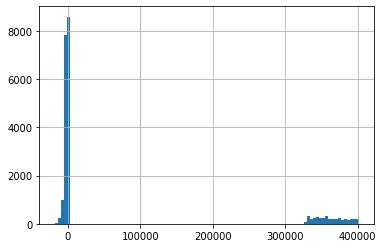

In [39]:
data['days_employed'].hist(bins=100)
data['days_employed'].describe()

count    2.152500e+04
mean     1.652253e+05
std      9.804367e+04
min      2.066726e+04
25%      1.077982e+05
50%      1.425944e+05
75%      1.955499e+05
max      2.265604e+06
Name: total_income, dtype: float64

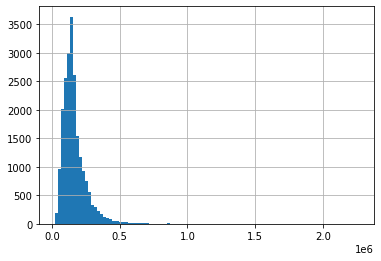

In [40]:
data['total_income'].hist(bins=100)
data['total_income'].describe()

Помимо [ранее](#2.2) описанных аномалий, после просмотра всех уникальных значений столбцов, были выевлены следующие:
1. Количество детей не может быть -1 и 20 детей маловероятно.
2. Имеются клиенты с возростом 0.

Сейчас мы это тоже исправим.

В столбце `children` встречается значение 20. Заменим на 2 и проверим результат.

In [41]:
# замена значения дети с 20 на 2
data['children'] = data['children'].replace(20, 2)
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4,  5])

In [42]:
# исправим отрицательные значения в стаже и количестве детей
data[['days_employed', 'children']] = data[['days_employed', 'children']].abs()
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Столбец `dob_years` содержит ноль. Посчитаем их количество и заменим средним значением.

In [43]:
#количество 0
data[data['dob_years'] == 0]['dob_years'].count()

101

In [44]:
# узнаем среднее значение возраста в каждом типе занятости
data.pivot_table(index='income_type', values='dob_years', aggfunc='mean')

,dob_years
income_type,
безработный,38.000000
в декрете,39.000000
госслужащий,40.636737
компаньон,39.697542
пенсионер,59.063019
предприниматель,42.500000
сотрудник,39.821027
студент,22.000000


Столбец `dob_years` типа **int**, поэтому впишем целые числа. Обычно считаются полные года, а не 39.6 лет. Поэтому смело округлим в меньшую сторону.

In [45]:
# заменяем 0 на среднее значение и проверим результат
data.loc[(data['income_type'] == 'безработный ') & (data['dob_years'] == 0), 'dob_years'] = 38
data.loc[(data['income_type'] == 'в декрете') & (data['dob_years'] == 0), 'dob_years'] = 39
data.loc[(data['income_type'] == 'госслужащий') & (data['dob_years'] == 0), 'dob_years'] = 40
data.loc[(data['income_type'] == 'компаньон') & (data['dob_years'] == 0), 'dob_years'] = 39
data.loc[(data['income_type'] == 'пенсионер') & (data['dob_years'] == 0), 'dob_years'] = 60
data.loc[(data['income_type'] == 'предприниматель') & (data['dob_years'] == 0), 'dob_years'] = 42
data.loc[(data['income_type'] == 'сотрудник') & (data['dob_years'] == 0), 'dob_years'] = 39
data.loc[(data['income_type'] == 'студент') & (data['dob_years'] == 0), 'dob_years'] = 22


data[data['dob_years'] == 0]['dob_years'].count()

0

В столбце `days_employed` есть значения стажа больше 800 лет. Посчитаем их количество и решим, что с ними делать.

In [46]:
data[data['days_employed'] > 30000]['days_employed'].count()

3853

Аномальных значений слишком много, что бы от них отказаться. Заменим медианными значениями.

In [47]:
# уберем значения больше 30000 дней
# появившиеся пустые значения, заменим медианным
data['days_employed'] = (
    data['days_employed']
    .where(data['days_employed'] < 30000)
)
data.loc[data['days_employed'].isna(), 'days_employed'] = (
    data.groupby('dob_years')['days_employed']
    .transform('median')
)

Проверим результат.

count    21525.000000
mean      2299.522173
std       2027.354247
min         24.141633
25%        974.845642
50%       1832.564621
75%       2911.913670
max      18388.949901
Name: days_employed, dtype: float64

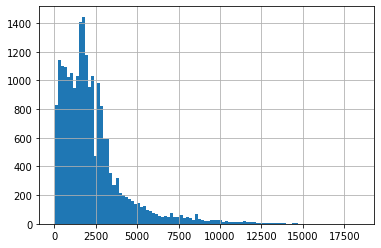

In [48]:
data['days_employed'].hist(bins=100)
data['days_employed'].describe()

Теперь максимальный стаж около 50 лет. Выглядит правдоподобно.

В столбцах `education` и `family_status` значение с разными регистрами. Приведем к единому строчному регистру и проверим результат.

In [49]:
# строчный регистр и вывод результата
data['education'] = data['education'].str.lower()
data['family_status'] = data['family_status'].str.lower()
display(data['education'].unique(), data['family_status'].unique())

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

Столбец `gender` содержит значение **XNA**. Узнаем количество пропущенных значений.

In [50]:
data[data['gender'] == 'XNA']['gender'].count()

1

Значение встречается только один раз. Можно его исключить из анализа, на результат это не повлияет.

In [51]:
data = data[data['gender'] != 'XNA']
data['gender'].unique()

array(['F', 'M'], dtype=object)

### Шаг 2.3. Изменение типов данных.

Столбцы `days_employed` и `total_income` приведем к целочисленным значениям.

In [52]:
# изменим тип данных и проверим результат
data['days_employed'] = data['days_employed'].astype('int')
data['total_income'] = data['total_income'].astype('int')
data.dtypes

children             int64
days_employed        int64
dob_years            int64
education           object
education_id         int64
family_status       object
family_status_id     int64
gender              object
income_type         object
debt                 int64
total_income         int64
purpose             object
dtype: object

### Шаг 2.4. Удаление дубликатов.

Посчитаем количество дубликатов.

In [53]:
data.duplicated().sum()

71

Дубликаты могли появиться из-за технических ошибок или человеческого фактора.
Но если мы говорим о кредите, то клиент мог его рефинансировать. В таком случае все данные, из преставленных нам, остануться прежними, а его сново занесут в базу данных.

Избавимся от дубликатов и проверим результат.

In [54]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

Создадим два новых датафрейма со столбцами:

* `education_id` и `education` — в первом;
* `family_status_id` и `family_status` — во втором.

In [55]:
education = data[['education_id', 'education']]
education = education.drop_duplicates().reset_index(drop=True)
display(education)
family_status = data[['family_status_id', 'family_status']]
family_status = family_status.drop_duplicates().reset_index(drop=True)
display(family_status)

,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,не женат / не замужем


Удалим из исходного датафрейма столбцы `education` и `family_status`, оставив только их идентификаторы: `education_id` и `family_status_id`.

In [56]:
data = data.drop('education', axis=1)
data = data.drop('family_status', axis=1)

Проверим результат.

In [57]:
data.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,0,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,1,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,1,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,1,0,M,сотрудник,0,267628,дополнительное образование
4,0,1846,53,1,1,F,пенсионер,0,158616,сыграть свадьбу


### Шаг 2.6. Категоризация дохода.

На основании диапазонов, указанных ниже, создадим столбец `total_income_category` с категориями:
* 0–30000 — 'E';
* 30001–50000 — 'D';
* 50001–200000 — 'C';
* 200001–1000000 — 'B';
* 1000001 и выше — 'A'.

In [58]:
# создадим функцию, для присвоения категорий
# создадим новый столбец и запишим в него данные категорий
def total_income_category(income):
    try:
        if income <= 30000:
            return 'E'
        if income >= 30001 and income <= 50000:
            return 'D'
        if income >= 50001 and income <= 200000:
            return 'C'
        if income >= 200001 and income <= 1000000:
            return 'B'
        if income >= 1000001:
            return 'A'
    except:
        print('Значение не входит ни в один диапозон')

data['total_income_category'] = data['total_income'].apply(total_income_category)
data.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,8437,42,0,0,F,сотрудник,0,253875,покупка жилья,B
1,1,4024,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,C
2,0,5623,33,1,0,M,сотрудник,0,145885,покупка жилья,C
3,3,4124,32,1,0,M,сотрудник,0,267628,дополнительное образование,B
4,0,1846,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,C


### Шаг 2.7. Категоризация целей кредита.

Создайте функцию, которая на основании данных из столбца purpose сформирует новый столбец `purpose_category`, в который войдут следующие категории:
* операции с автомобилем,
* операции с недвижимостью,
* проведение свадьбы,
* получение образования.

In [59]:
def purpose_category(purpose):
    if 'автомоб' in purpose :
        return 'операции с автомобилем'
    if 'жиль' in purpose :
        return 'операции с недвижимостью'
    if 'недвиж' in purpose :
        return 'операции с недвижимостью'
    if 'свадь' in purpose :
        return 'проведение свадьбы'
    if 'образов' in purpose :
        return 'получение образования'
    
data['purpose_category'] = data['purpose'].apply(purpose_category)
data.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,8437,42,0,0,F,сотрудник,0,253875,покупка жилья,B,операции с недвижимостью
1,1,4024,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем
2,0,5623,33,1,0,M,сотрудник,0,145885,покупка жилья,C,операции с недвижимостью
3,3,4124,32,1,0,M,сотрудник,0,267628,дополнительное образование,B,получение образования
4,0,1846,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы


### Ответы на вопросы.

##### Вопрос 1:

Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [60]:
children_stat = data.pivot_table(index='children', values=['debt'], aggfunc=['count', 'sum', 'mean'])
children_stat.columns = ['total_borrowers', 'total_debtors', 'share_of_debtors']
display(children_stat)

,total_borrowers,total_debtors,share_of_debtors
children,,,
0,14090,1063,0.075444
1,4855,445,0.091658
2,2128,202,0.094925
3,330,27,0.081818
4,41,4,0.097561
5,9,0,0.000000


##### Вывод 1:

Самые ответственные клиенты без детей (из 14090 кредитополучателей, 7.5% невозврата в срок), а самые безответственные с 4-мя детьми (из 41 кредитополучателя, 9.7% невозврата в срок). 

Выборка с 5 детьми состоит всего из 9 человек, соответственно, по ней нельзя делать выводы, поскольку она слишком маленькая.

##### Вопрос 2:

Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [61]:
# обьединим две таблицы и удалим лишний столбец
family_stat = data.pivot_table(index='family_status_id', values=['debt'], aggfunc=['count', 'sum', 'mean'])
family_stat.columns = ['total_borrowers', 'total_debtors', 'share_of_debtors']
family_stat_new = pd.merge(family_status, family_stat, on='family_status_id', how='inner')
family_stat_final = family_stat_new.drop(columns='family_status_id')

display(family_stat_final)

,family_status,total_borrowers,total_debtors,share_of_debtors
0,женат / замужем,12339,931,0.075452
1,гражданский брак,4150,388,0.093494
2,вдовец / вдова,959,63,0.065693
3,в разводе,1195,85,0.071130
4,не женат / не замужем,2810,274,0.097509


##### Вывод 2:

Самые ответственные клиенты с семейным положением "вдовец / вдова" (из 959 кредитополучателей, 6.5% невозврата в срок), а самые безответственные с семейным положением "не женат / не замужем" (из 2810 кредитополучателей, 9.7% невозврата в срок).

##### Вопрос 3:

Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [62]:
total_income_category_stat = data.pivot_table(index='total_income_category', values=['debt'], aggfunc=['count', 'sum', 'mean'])
total_income_category_stat.columns = ['total_borrowers', 'total_debtors', 'share_of_debtors']
display(total_income_category_stat)

,total_borrowers,total_debtors,share_of_debtors
total_income_category,,,
A,25,2,0.080000
B,5041,356,0.070621
C,16015,1360,0.084920
D,350,21,0.060000
E,22,2,0.090909


* 0–30000 — 'E';
* 30001–50000 — 'D';
* 50001–200000 — 'C';
* 200001–1000000 — 'B';
* 1000001 и выше — 'A'.

##### Вывод 3:

Самые ответственные клиенты с доходами 30001–50000 (из 350	кредитополучателей, 6% невозврата в срок), а самые безответственные с доходами 0–30000 (из 22 кредитополучателей, 9% невозврата в срок).

##### Вопрос 4:

Как разные цели кредита влияют на его возврат в срок?

In [63]:
purpose_category_stat = data.pivot_table(index='purpose_category', values=['debt'], aggfunc=['count', 'sum', 'mean'])
purpose_category_stat.columns = ['total_borrowers', 'total_debtors', 'share_of_debtors']
display(purpose_category_stat)

,total_borrowers,total_debtors,share_of_debtors
purpose_category,,,
операции с автомобилем,4306,403,0.093590
операции с недвижимостью,10810,782,0.072340
получение образования,4013,370,0.092200
проведение свадьбы,2324,186,0.080034


##### Вывод 4:


Самые надежные клиенты берущие кредит для покупки недвижимости (из 10810 кредитополучателей, 7.2% невозврата в срок), а самые безответственные те, кто взял кредит для покупки автомобиля (из 4306 кредитополучателей, 9.3% невозврата в срок).

## Общий вывод:

Семейное положение и количество детей клиента влияет на факт погашения кредита в срок. 

Самые ответственные клиенты:
* с семейным положением "вдовец / вдова" (из 959 кредитополучателей, 6.5% невозврата в срок) 
* без детей (из 14090 кредитополучателей, 7.5% невозврата в срок). 

Самые безответственные:
* с семейным положением "не женат / не замужем" (из 2810 кредитополучателей, 9.7% невозврата в срок) 
* с 4-мя детьми (из 41 кредитополучателя, 9.7% невозврата в срок).

Самый лучший клиент для банка, это клиент с семейным положением "вдовец / вдова", без детей, с уровнем дохода 30 001 – 50 000 и целью преобретения недвижимости.